# Matching Etc

Looking mostly at the stuff from the second day, including matching algorithms, and at how the causal inference module works.

In [1]:
import sys
sys.path.append('../causal_faker')

from causal_faker import CausalFaker

import matplotlib.pyplot as plt

import numpy as np

from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols
%matplotlib inline

### Simple Mathcing

In [2]:
from causalinference import CausalModel

In [3]:
# This is your main class into the model, documentation is quite spartan.
CausalModel

causalinference.causal.CausalModel

In order to show what is meant here we usually want a variable x, that is binary, and a confounder, which can be continous or binary.

Start quite simple ...

In [5]:
# This is what we are trying to estimate ultimately ...
f = 0.22


cf = CausalFaker(
    {(0, 3): 0.4,
     (2, 4): 0.3,
     (1, 3): 0.5,
     (1, 4): 0.8,
     (3, 4): f
    }
)

data = cf.get_df(1500, named_cols=True)

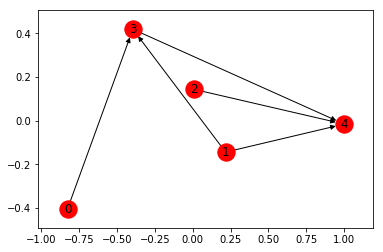

In [7]:
cf.draw()

My module doesn't do binary data very well, so let's make one of our variables binary.

In [8]:
from seaborn import pairplot

In [9]:
data.x_3 = (data.x_3 > data.x_3.median()).astype(int)

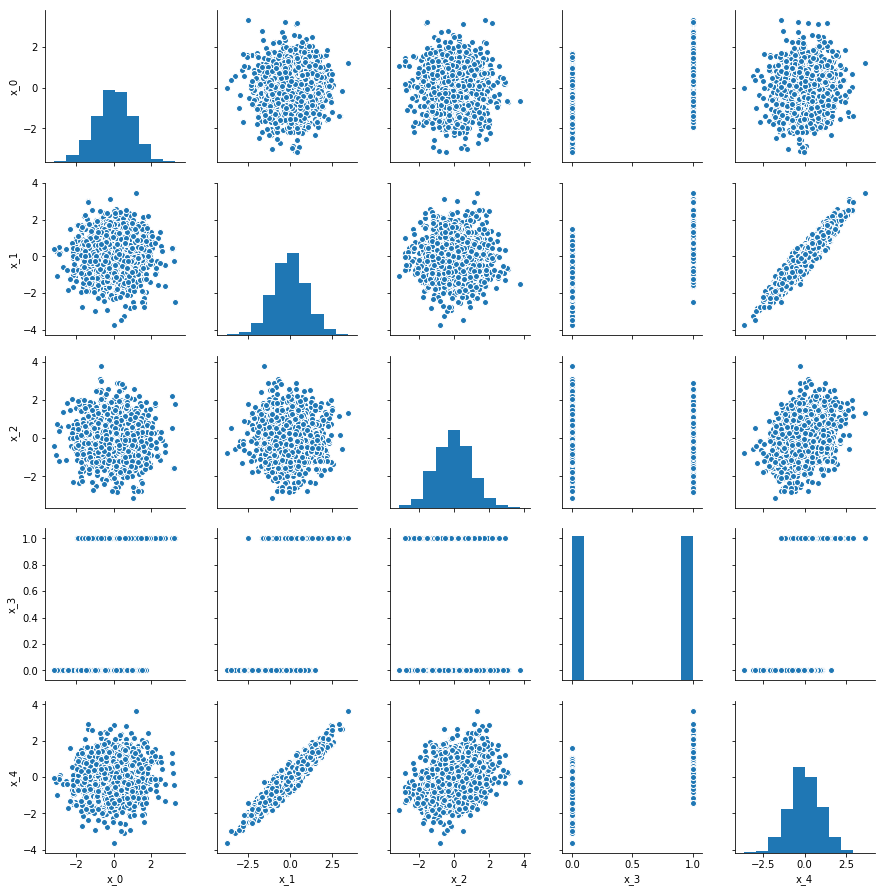

In [10]:
pairplot(data)

Now x_3 is binary, but still dependent on the other variables specified in the model.

Let's see what the average effect of our treatment is on our outcome variable.

In [37]:
data.groupby('x_3').mean().x_4

x_3
0   -0.594901
1    0.623863
Name: x_4, dtype: float64

What would our linear model do in this case?

In [42]:
ols(formula='x_4 ~ x_3', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    x_4   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     1016.
Date:                Sat, 30 Nov 2019   Prob (F-statistic):          1.36e-170
Time:                        18:08:53   Log-Likelihood:                -1676.8
No. Observations:                1500   AIC:                             3358.
Df Residuals:                    1498   BIC:                             3368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5949      0.027    -22.000      0.000      -0.648      -0.542
x_3            1.2188      0.038     31.870      0.000       1.144       1.294
==============================================================================
Omnibus:                        7.551   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                8.597
Skew:                           0.097   Prob(JB):                       0.0136
Kurtosis:                       3.316   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
ols(formula='x_4 ~ x_3 + x_1', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    x_4   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     6676.
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:09:21   Log-Likelihood:                -344.26
No. Observations:                1500   AIC:                             694.5
Df Residuals:                    1497   BIC:                             710.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0575      0.013     -4.507      0.000      -0.083      -0.033
x_3            0.1201      0.020      5.921      0.000       0.080       0.160
x_1            0.8654      0.010     85.740      0.000       0.846       0.885
==============================================================================
Omnibus:                        1.588   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.452   Jarque-Bera (JB):                1.601
Skew:                          -0.079   Prob(JB):                        0.449
Kurtosis:                       2.978   Cond. No.                         3.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And what does mathcing do in this case?

This class can do the magic. It wants np arrays, lists of pandas series don't cut it.

In [59]:
cm = CausalModel(Y=data.x_4.values,
            D=data.x_1.values,
            X=data.x_3.values
           )

In [60]:
cm.est_via_matching()
cm.estimates

IndexError: index 104 is out of bounds for axis 0 with size 6